In [ ]:
# ============================================
# Thyroid Nodule Segmentation - Final Colab Script
# Paste into Colab. Expects ~256x256 grayscale images.
# ============================================

# --- 0. Installs (run in Colab) ---
!pip install -q albumentations==1.3.0 gdown tqdm

# --- 1. Imports ---
import os, time, copy, random, json
from zipfile import ZipFile
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import gdown

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

print("Imports done.")

# ============================================
# Dataset Download + Directory Creation + Splitting
# ============================================

import os, shutil, numpy as np
from zipfile import ZipFile
import gdown

# --- Download dataset ---
print("Downloading dataset...")
file_id = '1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F'
output_zip_path = 'Thyroid_Dataset.zip'
gdown.download(id=file_id, output=output_zip_path, quiet=False)
print("Download complete.")

# --- Unzip dataset ---
print("Unzipping dataset...")
with ZipFile(output_zip_path, 'r') as zip_ref:
    zip_ref.extractall('Thyroid_Data')
print("Unzipping complete.")

# --- Create clean train/test split structure ---
print("Creating Train/Test directories...")
base_path = 'data'
train_path = os.path.join(base_path, 'Train')
test_path = os.path.join(base_path, 'Test')

# Remove existing structure if exists
if os.path.exists(base_path):
    shutil.rmtree(base_path)

os.makedirs(os.path.join(train_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'Masks'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Masks'), exist_ok=True)
print("Directory structure created.")

# --- Define original dataset paths ---
path_img_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-image/'
path_mask_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-mask/'

image_files = sorted(os.listdir(path_img_folder))
mask_files = sorted(os.listdir(path_mask_folder))

# --- Shuffle and split (70/30 train-test) ---
indices = np.arange(len(image_files))
np.random.shuffle(indices)

split_point = int(0.7 * len(image_files))
train_indices = indices[:split_point]
test_indices = indices[split_point:]

print("Splitting and moving files...")
for idx in train_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(train_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(train_path, 'Masks', mask_files[idx]))

for idx in test_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(test_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(test_path, 'Masks', mask_files[idx]))

print(f"Data split complete. {len(train_indices)} training samples, {len(test_indices)} testing samples.")

# --- Updated paths for rest of training pipeline ---
train_img_dir = os.path.join(train_path, "Images")
train_mask_dir = os.path.join(train_path, "Masks")
test_img_dir  = os.path.join(test_path, "Images")
test_mask_dir = os.path.join(test_path, "Masks")

print("Final dataset paths:")
print("Train images:", train_img_dir)
print("Train masks :", train_mask_dir)
print("Test images :", test_img_dir)
print("Test masks  :", test_mask_dir)

# --- 4. Utilities: pairing & quick mask checks ---
def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".tif")
    return sorted([os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith(exts)])

def pair_sorted(img_dir, mask_dir):
    imgs = list_images(img_dir)
    masks = list_images(mask_dir)
    if len(imgs) != len(masks):
        print("Warning: number of images and masks differ. Pairing by sorted order; verify filenames.")
    pairs = list(zip(sorted(imgs), sorted(masks)))
    return pairs

train_pairs = pair_sorted(train_img_dir, train_mask_dir)
test_pairs  = pair_sorted(test_img_dir, test_mask_dir)

print(f"Found pairs -> train: {len(train_pairs)}, test: {len(test_pairs)}")

# Quick mask stats (first 6)
print("Sample mask unique values (first 6):")
for _, mp in train_pairs[:6]:
    m = np.array(Image.open(mp).convert("L"))
    print(os.path.basename(mp), np.unique(m)[:6])

# --- 5. Dataset & transforms (256x256) ---
IMG_SIZE = 256

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=Image.NEAREST),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.4, interpolation=Image.NEAREST),
    A.RandomBrightnessContrast(p=0.4),
    A.GridDistortion(p=0.2),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=Image.NEAREST),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2()
])

class ThyroidDataset(Dataset):
    def __init__(self, pairs, transform=None, auto_invert=False):
        self.pairs = pairs
        self.transform = transform
        self.auto_invert = auto_invert
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]
        img = np.array(Image.open(img_p).convert("L"))
        mask = np.array(Image.open(mask_p).convert("L"))
        # threshold
        mask_bin = (mask > 128).astype("float32")
        # optional auto invert (dataset-level) - keep False at creation; we will auto-detect below
        if self.auto_invert:
            mask_bin = 1.0 - mask_bin
        if self.transform:
            aug = self.transform(image=img, mask=mask_bin)
            img_t = aug["image"]
            mask_t = aug["mask"].unsqueeze(0).float()
        else:
            img_t = torch.from_numpy(img).unsqueeze(0).float()/255.0
            img_t = (img_t - 0.5) / 0.5
            mask_t = torch.from_numpy(mask_bin).unsqueeze(0).float()
        return img_t, mask_t

# --- 6. Auto-detect mask polarity (are masks inverted?) ---
# Inspect a handful-> compute mean positive fraction. If average positive fraction > 0.5, likely inverted.
def detect_mask_polarity(pairs, sample_n=20):
    fracs = []
    for i, (_, mp) in enumerate(pairs[:sample_n]):
        m = np.array(Image.open(mp).convert("L"))
        m_bin = (m > 128).astype(np.float32)
        fracs.append(m_bin.mean())
    avg = np.mean(fracs)
    print(f"Average positive fraction across {len(fracs)} masks: {avg:.4f}")
    # If avg > 0.5, that suggests masks label background as 1 (inverted); return True to invert
    return avg > 0.5

invert_needed = detect_mask_polarity(train_pairs + test_pairs)
print("Auto-detected invert_masks =", invert_needed)

# Create datasets using auto-invert if needed
train_ds = ThyroidDataset(train_pairs, transform=train_transform, auto_invert=invert_needed)
val_ds   = ThyroidDataset(test_pairs, transform=val_transform, auto_invert=invert_needed)

# dataloaders
BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- 7. Model: Residual U-Net (logits output) ---
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        r = self.res(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + r)

class UNetRes(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = ResidualBlock(1, 64)
        self.e2 = ResidualBlock(64, 128)
        self.e3 = ResidualBlock(128, 256)
        self.e4 = ResidualBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.b = ResidualBlock(512, 1024)
        self.u4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.d4 = ResidualBlock(1024, 512)
        self.u3 = nn.ConvTranspose2d(512, 256, 2, stride=2); self.d3 = ResidualBlock(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, stride=2); self.d2 = ResidualBlock(256, 128)
        self.u1 = nn.ConvTranspose2d(128, 64, 2, stride=2);  self.d1 = ResidualBlock(128, 64)
        self.final = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        e4 = self.e4(self.pool(e3))
        b  = self.b(self.pool(e4))
        d4 = self.u4(b); d4 = self.d4(torch.cat([d4, e4], dim=1))
        d3 = self.u3(d4); d3 = self.d3(torch.cat([d3, e3], dim=1))
        d2 = self.u2(d3); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.final(d1)  # logits

# --- 8. Loss: Focal + BCEWithLogits + Dice combination ---
class FocalBCE(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        # logits: Bx1xHxW, targets: Bx1xHxW
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        p_t = probs*targets + (1-probs)*(1-targets)
        focal_factor = (1 - p_t) ** self.gamma
        loss = self.alpha * focal_factor * bce
        return loss.mean()

focal_bce = FocalBCE(alpha=0.25, gamma=2.0)

def dice_loss_from_logits(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    inter = (probs * targets).sum(dim=(1,2,3))
    denom = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2.*inter + smooth) / (denom + smooth)
    return 1 - dice.mean()

def combined_loss(logits, targets):
    return focal_bce(logits, targets) + dice_loss_from_logits(logits, targets)

# --- 9. Metrics ---
def dice_metric(logits, targets, thr=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2.*inter + 1e-6) / (union + 1e-6)
    return dice.mean().item()

def pixel_accuracy(logits, targets, thr=0.5):
    preds = (torch.sigmoid(logits) > thr).float()
    return (preds == targets).float().mean().item()

# --- 10. Post-processing: remove large components (gland) ---
import cv2
def remove_large_components(binary_mask, max_area_frac=0.15):
    # binary_mask: HxW numpy 0/1
    h, w = binary_mask.shape
    max_area = h * w * max_area_frac
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask.astype('uint8'), connectivity=8)
    out = np.zeros_like(binary_mask, dtype=np.uint8)
    for lab in range(1, num_labels):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area <= max_area:
            out[labels == lab] = 1
    return out

# --- 11. Training / evaluation loops ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetRes().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Remove verbose=True from ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = total_dice = total_acc = 0.0
    steps = 0
    for imgs, masks in tqdm(loader):
        imgs = imgs.to(device); masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
        total_dice += dice_metric(logits, masks)
        total_acc  += pixel_accuracy(logits, masks)
        steps += 1
    return total_loss/steps, total_dice/steps, total_acc/steps

def validate(model, loader, device):
    model.eval()
    total_loss = total_dice = total_acc = 0.0
    steps = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs = imgs.to(device); masks = masks.to(device)
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            total_loss += loss.item()
            total_dice += dice_metric(logits, masks)
            total_acc  += pixel_accuracy(logits, masks)
            steps += 1
    return total_loss/steps, total_dice/steps, total_acc/steps

# --- 12. Train loop w/ checkpointing ---
EPOCHS = 20
best_val_dice = -1.0
best_state = None
history = {"train_loss":[], "train_dice":[], "train_acc":[], "val_loss":[], "val_dice":[], "val_acc":[]}

for epoch in range(EPOCHS):
    t0 = time.time()
    tr_loss, tr_d, tr_acc = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_loss, val_d, val_acc = validate(model, val_loader, DEVICE)
    scheduler.step(val_d)
    history["train_loss"].append(tr_loss); history["train_dice"].append(tr_d); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss); history["val_dice"].append(val_d); history["val_acc"].append(val_acc)
    t1 = time.time()
    print(f"Epoch {epoch+1}/{EPOCHS} time={t1-t0:.1f}s | tr_loss={tr_loss:.4f} tr_d={tr_d:.4f} tr_acc={tr_acc:.4f} | val_loss={val_loss:.4f} val_d={val_d:.4f} val_acc={val_acc:.4f}")
    if val_d > best_val_dice:
        best_val_dice = val_d
        best_state = copy.deepcopy(model.state_dict())
        print("  -> New best model (val dice improved)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 7.1 MB/s eta 0:00:00
Imports done.


Downloading...
From (original): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F
From (redirected): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F&confirm=t&uuid=9628490a-cb32-4cab-a629-0214b1f42129
To: /content/Thyroid_Dataset.zip
100%|██████████| 395M/395M [00:07<00:00, 53.4MB/s]


Download complete.
Unzipping dataset...
Unzipping complete.
Creating Train/Test directories...
Directory structure created.
Splitting and moving files...
Data split complete. 2509 training samples, 1076 testing samples.
Final dataset paths:
Train images: data/Train/Images
Train masks : data/Train/Masks
Test images : data/Test/Images
Test masks  : data/Test/Masks
Found pairs -> train: 2509, test: 1076
Sample mask unique values (first 6):
0000.jpg [0 1 2 3 4 5]
0001.jpg [0 1 2 3 4 5]
0003.jpg [0 1 2 3 4 5]
0004.jpg [0 1 2 3 4 5]
0005.jpg [0 1 2 3 4 5]
0006.jpg [0 1 2 3 4 5]
Average positive fraction across 20 masks: 0.0673
Auto-detected invert_masks = False


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 1/20 time=204.8s | tr_loss=0.3888 tr_d=0.7001 tr_acc=0.9451 | val_loss=0.2252 val_d=0.8080 val_acc=0.9737
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:26<00:00,  5.01it/s]


Epoch 2/20 time=207.2s | tr_loss=0.2690 tr_d=0.7704 tr_acc=0.9680 | val_loss=0.2171 val_d=0.8104 val_acc=0.9766
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.97it/s]


Epoch 3/20 time=207.3s | tr_loss=0.2282 tr_d=0.8054 tr_acc=0.9728 | val_loss=0.1765 val_d=0.8494 val_acc=0.9781
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 4/20 time=208.0s | tr_loss=0.2163 tr_d=0.8151 tr_acc=0.9743 | val_loss=0.1717 val_d=0.8526 val_acc=0.9778
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.96it/s]


Epoch 5/20 time=208.2s | tr_loss=0.1954 tr_d=0.8332 tr_acc=0.9766 | val_loss=0.1385 val_d=0.8818 val_acc=0.9825
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.98it/s]


Epoch 6/20 time=208.0s | tr_loss=0.1916 tr_d=0.8361 tr_acc=0.9772 | val_loss=0.1511 val_d=0.8710 val_acc=0.9812


100%|██████████| 135/135 [00:27<00:00,  4.96it/s]


Epoch 7/20 time=207.5s | tr_loss=0.1818 tr_d=0.8442 tr_acc=0.9783 | val_loss=0.1327 val_d=0.8864 val_acc=0.9838
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 8/20 time=207.8s | tr_loss=0.1783 tr_d=0.8474 tr_acc=0.9784 | val_loss=0.1231 val_d=0.8945 val_acc=0.9846
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 9/20 time=207.9s | tr_loss=0.1686 tr_d=0.8558 tr_acc=0.9798 | val_loss=0.1202 val_d=0.8971 val_acc=0.9850
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.90it/s]


Epoch 10/20 time=208.8s | tr_loss=0.1616 tr_d=0.8618 tr_acc=0.9805 | val_loss=0.1235 val_d=0.8942 val_acc=0.9845


100%|██████████| 135/135 [00:27<00:00,  4.99it/s]


Epoch 11/20 time=208.0s | tr_loss=0.1478 tr_d=0.8734 tr_acc=0.9823 | val_loss=0.1083 val_d=0.9078 val_acc=0.9862
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.96it/s]


Epoch 12/20 time=207.7s | tr_loss=0.1521 tr_d=0.8701 tr_acc=0.9815 | val_loss=0.1116 val_d=0.9049 val_acc=0.9859


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 13/20 time=208.0s | tr_loss=0.1397 tr_d=0.8811 tr_acc=0.9830 | val_loss=0.1042 val_d=0.9112 val_acc=0.9867
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 14/20 time=208.1s | tr_loss=0.1486 tr_d=0.8735 tr_acc=0.9815 | val_loss=0.1041 val_d=0.9113 val_acc=0.9865
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.98it/s]


Epoch 15/20 time=207.7s | tr_loss=0.1379 tr_d=0.8825 tr_acc=0.9830 | val_loss=0.1170 val_d=0.9000 val_acc=0.9853


100%|██████████| 135/135 [00:27<00:00,  4.96it/s]


Epoch 16/20 time=207.9s | tr_loss=0.1385 tr_d=0.8814 tr_acc=0.9833 | val_loss=0.0999 val_d=0.9148 val_acc=0.9873
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 17/20 time=207.9s | tr_loss=0.1266 tr_d=0.8924 tr_acc=0.9843 | val_loss=0.0958 val_d=0.9183 val_acc=0.9876
  -> New best model (val dice improved)


100%|██████████| 135/135 [00:27<00:00,  4.95it/s]


Epoch 18/20 time=208.2s | tr_loss=0.1328 tr_d=0.8865 tr_acc=0.9838 | val_loss=0.1088 val_d=0.9079 val_acc=0.9854


100%|██████████| 135/135 [00:27<00:00,  4.96it/s]


Epoch 19/20 time=207.9s | tr_loss=0.1359 tr_d=0.8838 tr_acc=0.9834 | val_loss=0.1036 val_d=0.9122 val_acc=0.9867


100%|██████████| 135/135 [00:27<00:00,  4.97it/s]

Epoch 20/20 time=208.0s | tr_loss=0.1330 tr_d=0.8860 tr_acc=0.9840 | val_loss=0.0947 val_d=0.9196 val_acc=0.9876
  -> New best model (val dice improved)


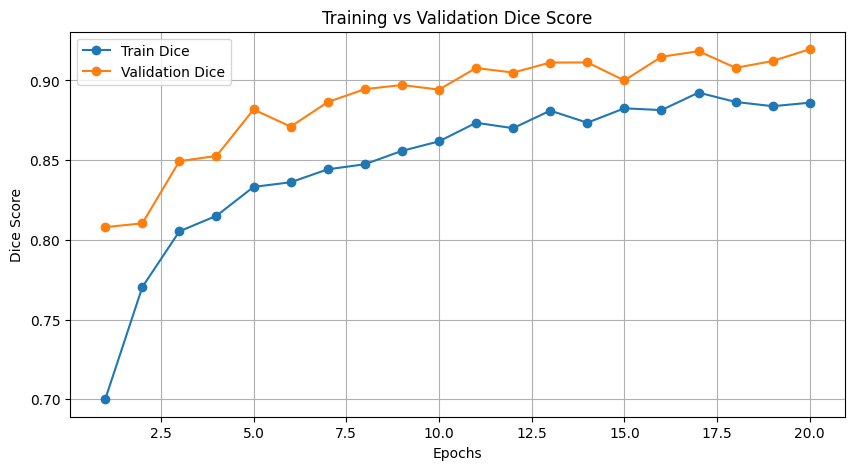

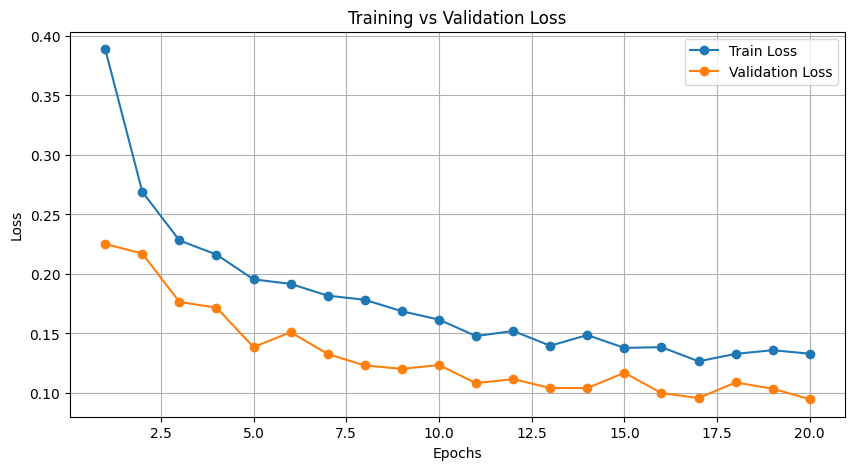

In [ ]:
import matplotlib.pyplot as plt

# --- Plot Training vs Validation Dice Score ---
plt.figure(figsize=(10,5))
# Use the lists from the history dictionary
plt.plot(range(1, len(history['train_dice'])+1), history['train_dice'], label='Train Dice', marker='o')
plt.plot(range(1, len(history['val_dice'])+1), history['val_dice'], label='Validation Dice', marker='o')
plt.title("Training vs Validation Dice Score")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training vs Validation Loss ---
plt.figure(figsize=(10,5))
# Use the lists from the history dictionary
plt.plot(range(1, len(history['train_loss'])+1), history['train_loss'], label='Train Loss', marker='o')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 13. Save best model and training history ---
OUT = os.path.join(train_path, "model_output")
os.makedirs(OUT, exist_ok=True)
MODEL_PATH = os.path.join(OUT, "thyroid_nodule_segmentation.pth")
if best_state is not None:
    torch.save(best_state, MODEL_PATH)
    print("Saved best model to:", MODEL_PATH)
torch.save(model.state_dict(), os.path.join(OUT, "last_epoch_model.pth"))
with open(os.path.join(OUT, "history.json"), "w") as f:
    json.dump(history, f)
print("Training complete. Best val Dice:", best_val_dice)

Saved best model to: data/Train/model_output/thyroid_nodule_segmentation.pth
Training complete. Best val Dice: 0.9195783601866828


In [ ]:
# --- Save smaller FP16 model ---
OUT = os.path.join(train_path, "model_output")
os.makedirs(OUT, exist_ok=True)

MODEL_PATH = os.path.join(OUT, "thyroid_nodule_segmentation_light.pth")

# Convert to float16 before saving to reduce size ~50%
state_dict = {k: v.half() for k, v in model.state_dict().items()}
torch.save(state_dict, MODEL_PATH)

print(f"✅ Lightweight FP16 model saved at: {MODEL_PATH}")

✅ Lightweight FP16 model saved at: data/Train/model_output/thyroid_nodule_segmentation_light.pth


Showing a few validation predictions (post-processed).
Model device: cuda:0
Input tensor device: cuda:0


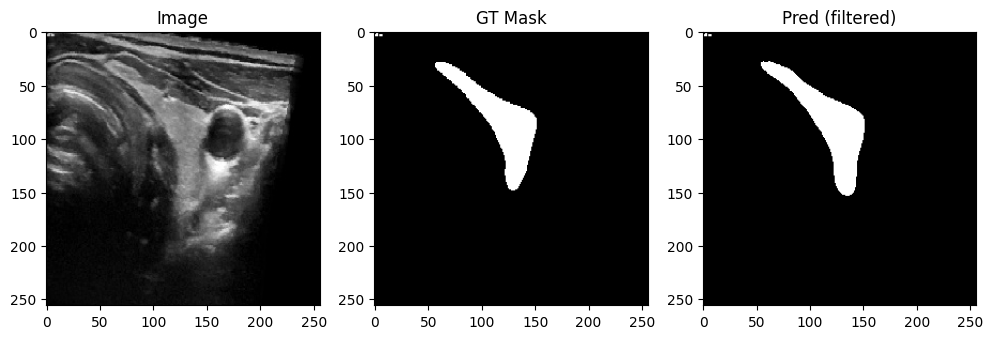

Model device: cuda:0
Input tensor device: cuda:0


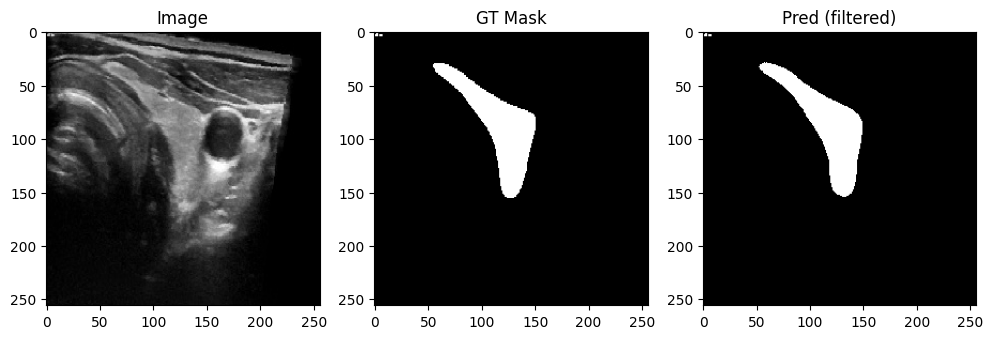

Model device: cuda:0
Input tensor device: cuda:0


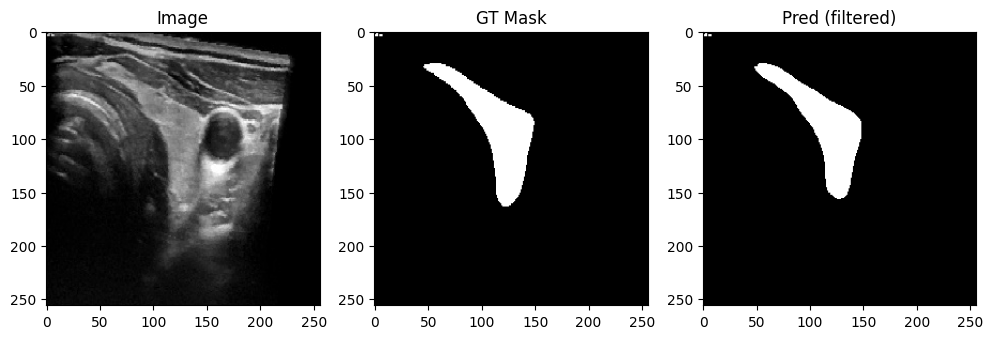

Model device: cuda:0
Input tensor device: cuda:0


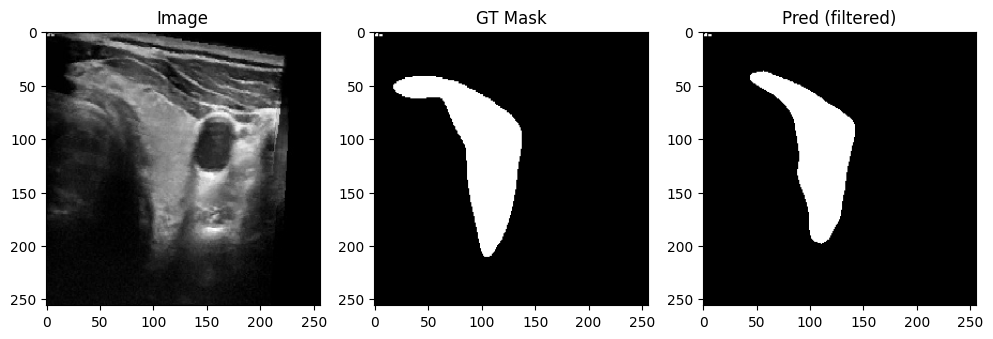

In [ ]:
# --- 14. Visual checks (display a few examples with postprocessing) ---
def show_predictions(model, dataset, device, n=4, thr=0.5):
    model.eval()
    for i in range(min(n, len(dataset))):
        img_t, gt = dataset[i]
        # Move input tensor to the same device as the model
        x = img_t.unsqueeze(0).to(device)

        # --- Added: Print device info for debugging ---
        print(f"Model device: {next(model.parameters()).device}")
        print(f"Input tensor device: {x.device}")
        # --- End Added ---

        with torch.no_grad():
            logits = model(x)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        pred = (probs > thr).astype(np.uint8)
        pred_filtered = remove_large_components(pred, max_area_frac=0.15)
        # display
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        axes[0].imshow(((img_t.numpy()[0]*0.5)+0.5), cmap='gray'); axes[0].set_title("Image")
        axes[1].imshow(gt.squeeze().numpy(), cmap='gray'); axes[1].set_title("GT Mask")
        axes[2].imshow(pred_filtered, cmap='gray'); axes[2].set_title("Pred (filtered)")
        plt.show()

print("Showing a few validation predictions (post-processed).")
# Explicitly move model to device before showing predictions
model.to(DEVICE)
show_predictions(model, val_ds, DEVICE, n=4, thr=0.5)

In [ ]:
%%writefile app.py
!pip install -q opencv-python-headless streamlit

import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import os

# --------------------------------------------
# Streamlit Page Setup
# --------------------------------------------
st.set_page_config(page_title="Thyroid Nodule Segmentation", layout="wide")
st.title("🩺 Thyroid Nodule Segmentation using Deep Learning")
st.markdown("Upload a thyroid ultrasound image to detect and visualize **thyroid nodules** (in red overlay).")

# --------------------------------------------
# 1️⃣ Model Definition (Residual U-Net)
# --------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        r = self.res(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + r)

class UNetRes(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = ResidualBlock(1, 64)
        self.e2 = ResidualBlock(64, 128)
        self.e3 = ResidualBlock(128, 256)
        self.e4 = ResidualBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.b = ResidualBlock(512, 1024)
        self.u4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.d4 = ResidualBlock(1024, 512)
        self.u3 = nn.ConvTranspose2d(512, 256, 2, stride=2); self.d3 = ResidualBlock(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, stride=2); self.d2 = ResidualBlock(256, 128)
        self.u1 = nn.ConvTranspose2d(128, 64, 2, stride=2);  self.d1 = ResidualBlock(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        e4 = self.e4(self.pool(e3))
        b  = self.b(self.pool(e4))
        d4 = self.u4(b); d4 = self.d4(torch.cat([d4, e4], dim=1))
        d3 = self.u3(d4); d3 = self.d3(torch.cat([d3, e3], dim=1))
        d2 = self.u2(d3); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.final(d1)

# --------------------------------------------
# 2️⃣ Post-Processing (remove large components)
# --------------------------------------------
def remove_large_components(binary_mask, max_area_frac=0.15):
    h, w = binary_mask.shape
    max_area = h * w * max_area_frac
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask.astype("uint8"), connectivity=8)
    out = np.zeros_like(binary_mask, dtype=np.uint8)
    for lab in range(1, num_labels):
        if stats[lab, cv2.CC_STAT_AREA] <= max_area:
            out[labels == lab] = 1
    return out

# --------------------------------------------
# 3️⃣ Model Loading
# --------------------------------------------
@st.cache_resource
def load_model():
    # Path to the original full model file
    model_path = "data/Train/model_output/thyroid_nodule_segmentation.pth"

    # Initialize model (same architecture used in training)
    model = UNetRes().to("cpu")

    # Load full precision model
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# --------------------------------------------
# 4️⃣ Image Upload + Preprocessing
# --------------------------------------------
uploaded_file = st.file_uploader("Upload a thyroid ultrasound image (grayscale):", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("L")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    input_tensor = transform(image).unsqueeze(0)

    # --- Inference ---
    with torch.no_grad():
        logits = model(input_tensor)
        pred_mask = torch.sigmoid(logits).squeeze().cpu().numpy()

    # --- Threshold ---
    threshold = st.slider("Select threshold for mask display", 0.0, 1.0, 0.5, 0.01)
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    # --- Post-Processing ---
    binary_mask_filtered = remove_large_components(binary_mask, max_area_frac=0.15)

    # --------------------------------------------
    # 5️⃣ Visualization (with Alpha Overlay)
    # --------------------------------------------
    st.header("🔍 Segmentation Result")

    # Convert to RGB for blending
    original_image_disp = image.convert("RGB")

    # Resize mask to match display size
    mask_resized = np.array(Image.fromarray(binary_mask_filtered * 255).resize(original_image_disp.size))

    # Create RGBA mask (red overlay)
    mask_rgba = np.zeros((mask_resized.shape[0], mask_resized.shape[1], 4), dtype=np.uint8)
    mask_rgba[..., 0] = 255  # red
    mask_rgba[..., 3] = mask_resized  # alpha mask

    mask_image = Image.fromarray(mask_rgba, mode="RGBA")
    alpha = 0.35  # overlay transparency (0 = invisible, 1 = opaque)
    overlay_image = Image.alpha_composite(original_image_disp.convert("RGBA"), mask_image)

    col1, col2, col3 = st.columns(3)
    with col1:
        st.image(original_image_disp, caption="Original Image", use_container_width=True)
    with col2:
        st.image(mask_image, caption="Predicted Mask (Transparent Red)", use_container_width=True)
    with col3:
        st.image(overlay_image, caption=f"Overlay Result (alpha={alpha})", use_container_width=True)

    st.markdown(f"**Note:** Red regions indicate detected thyroid nodules (Transparency α = {alpha}).")
else:
    st.info("👆 Please upload a thyroid ultrasound image to begin.")


Overwriting app.py


In [ ]:
%%writefile requirements.txt
streamlit==1.39.0
torch==2.4.0
torchvision==0.19.0
Pillow==10.4.0
numpy==1.26.4
matplotlib==3.9.2

Overwriting requirements.txt
